# Introduction to Model Pipelines

In this notebook, we implement a few simple pipelines using Scikit-Learn. To illustrate the procedures, we will use the dataset on [Wine Quality available in the UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/186/wine+quality).

In [1]:
%load_ext dotenv
%dotenv 
%run update_path.py

We use the [ucimlrepo](https://pypi.org/project/ucimlrepo/) package to easily access the data.

In [2]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 

wine_quality = fetch_ucirepo(id=186)

Inspect the object `wine_quality`, which contains useful information about the dataset. For example, use `wine_quality.keys()` to obtain the object's keys. 

In [3]:
wine_quality.keys()

dict_keys(['data', 'metadata', 'variables'])

In [4]:
wine_quality['metadata']

{'uci_id': 186,
 'name': 'Wine Quality',
 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality',
 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv',
 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).',
 'area': 'Business',
 'tasks': ['Classification', 'Regression'],
 'characteristics': ['Multivariate'],
 'num_instances': 4898,
 'num_features': 11,
 'feature_types': ['Real'],
 'demographics': [],
 'target_col': ['quality'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2009,
 'last_updated': 'Wed Nov 15 2023',
 'dataset_doi': '10.24432/C56S3T',
 'creators': ['Paulo Cortez',
  'A. Cerdeira',
  'F. Almeida',
  'T. Matos',
  'J. Reis'],
 'intro_paper': {'ID': 252,
  'type': 'NATIVE',
  'ti

In [5]:
wine_quality.data.keys()

dict_keys(['ids', 'features', 'targets', 'original', 'headers'])

In [6]:
dt = wine_quality.data.original
X = dt.drop(columns=['quality'])
Y = 1*(dt[['quality']] >= 7).values.ravel()


In [13]:
1*(dt[['quality']] >= 7).values.ravel()

array([0, 0, 0, ..., 0, 1, 0], shape=(6497,))

In [7]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  color                 6497 non-null   object 
dtypes: float64(11), object(1)
memory usage: 609.2+ KB


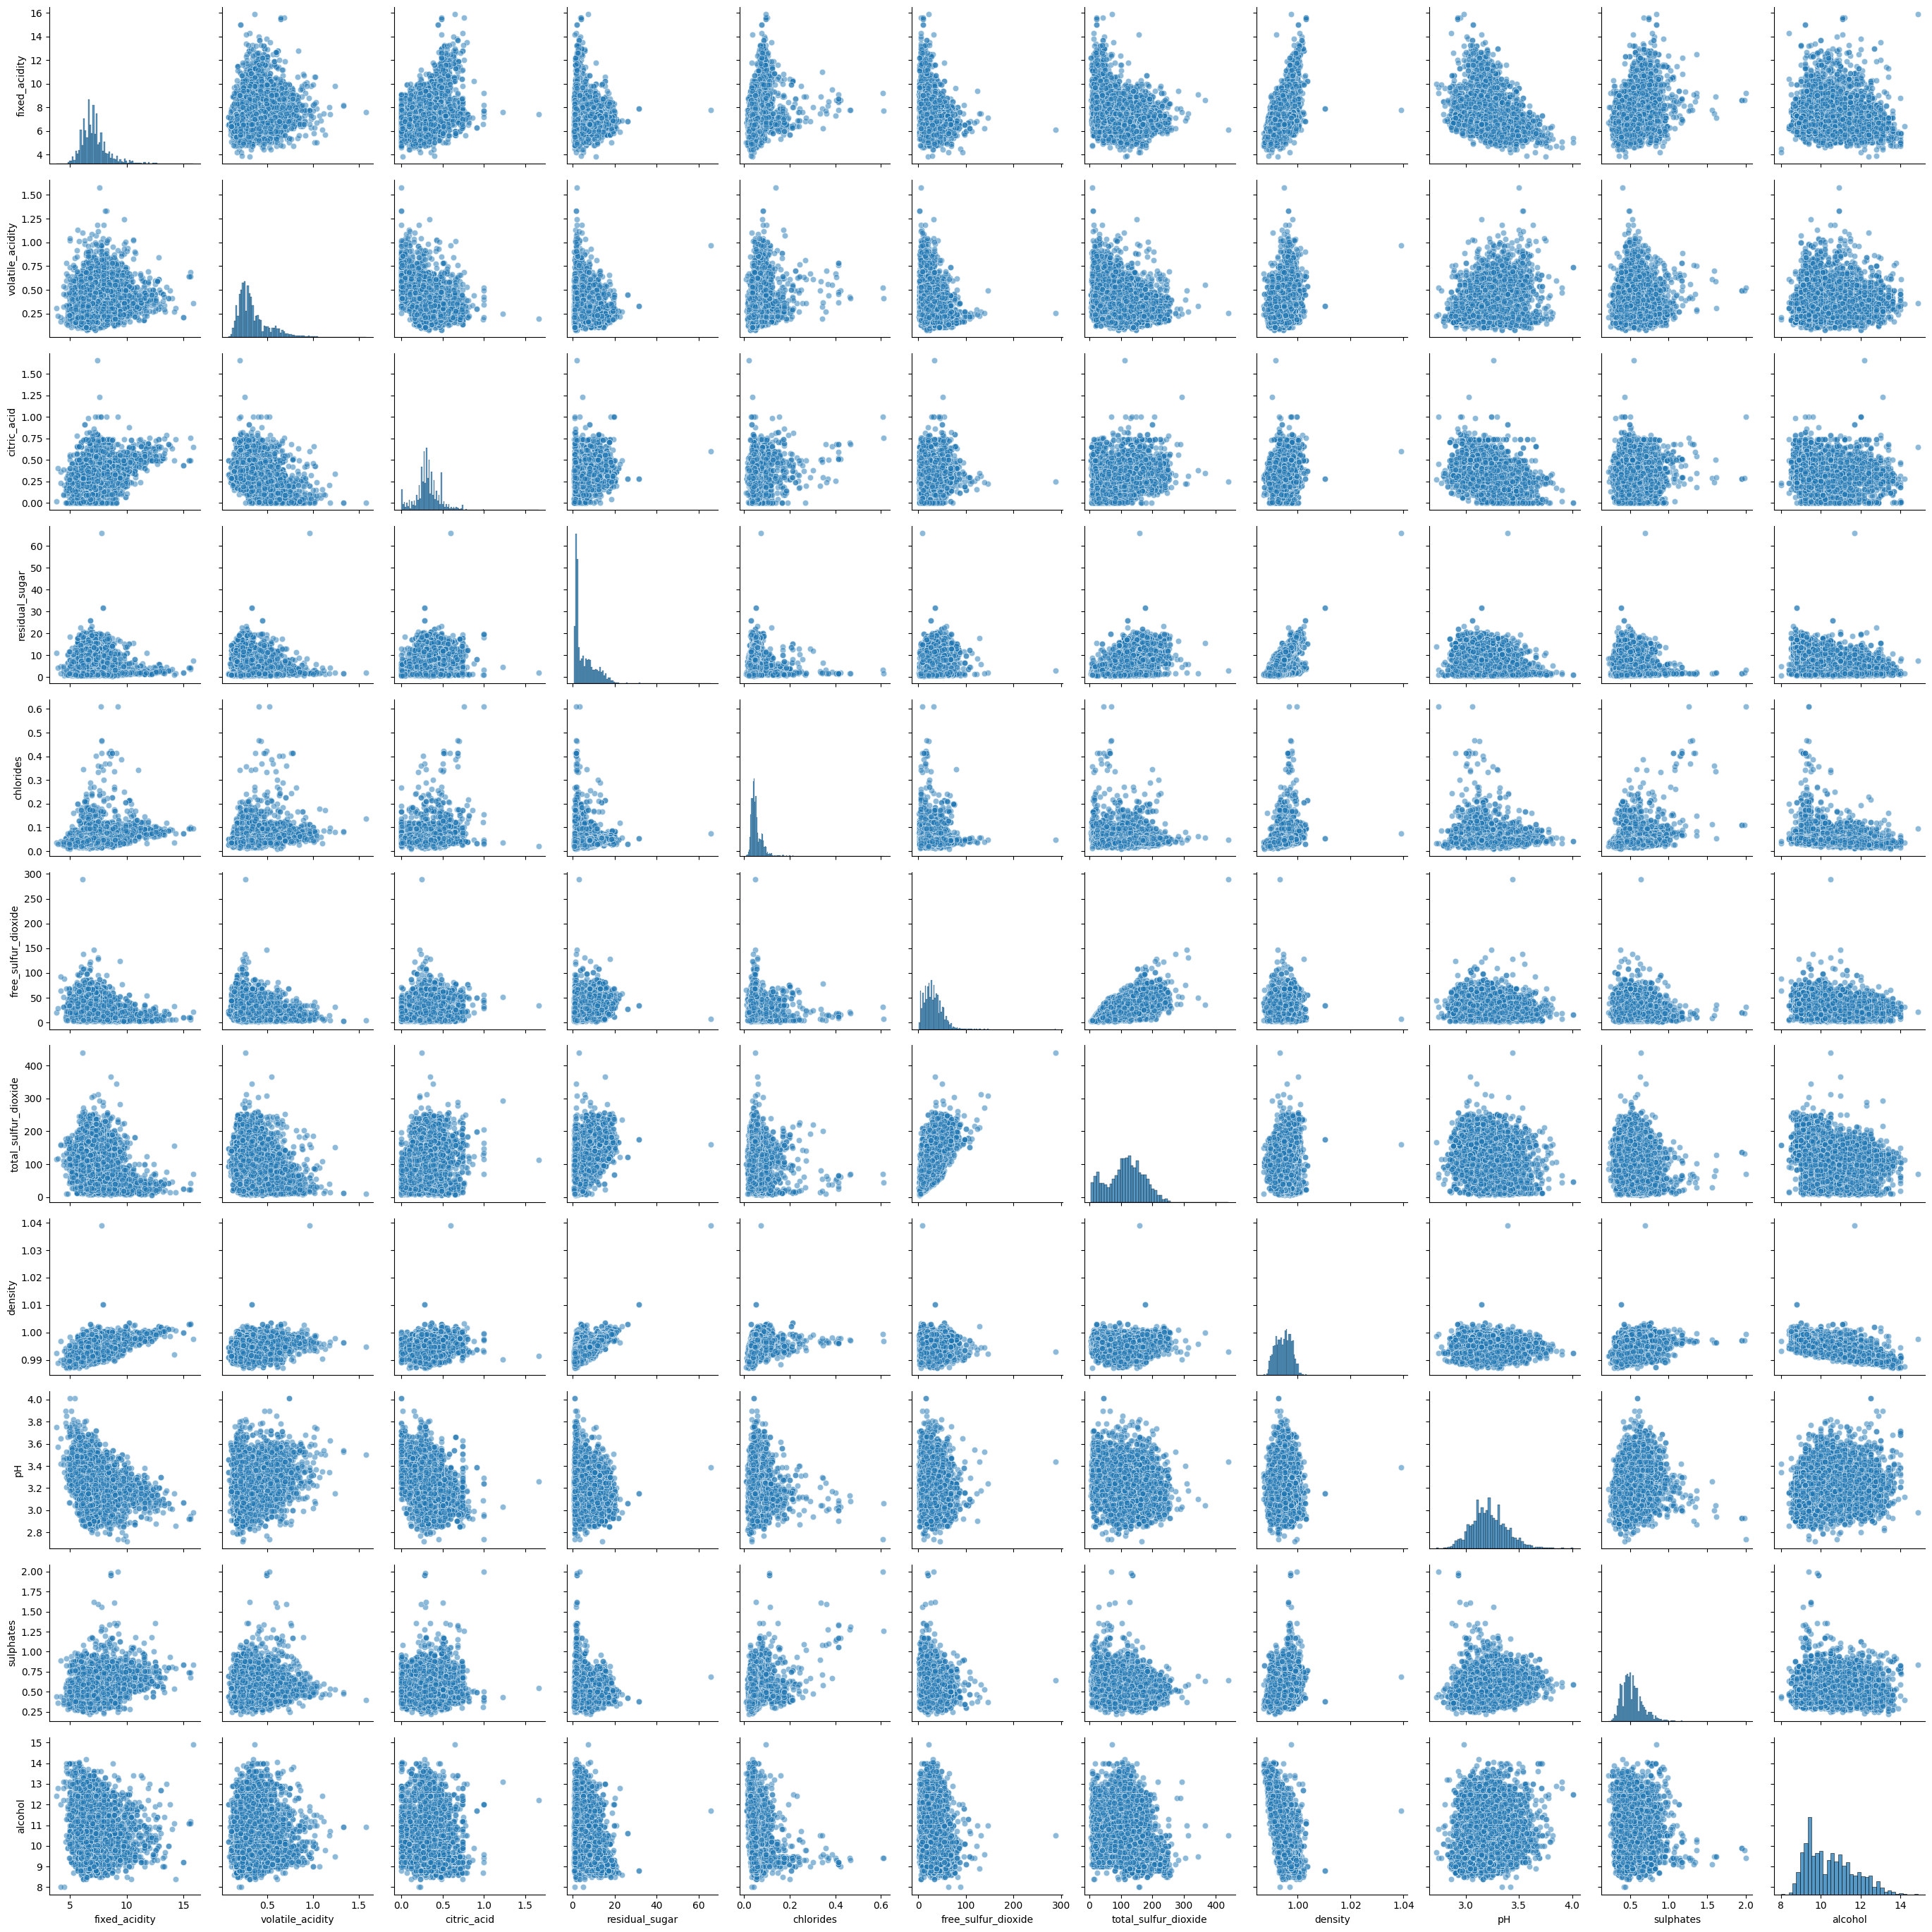

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(X, diag_kind='hist', plot_kws={'alpha': 0.5})
plt.tight_layout()
plt.show()

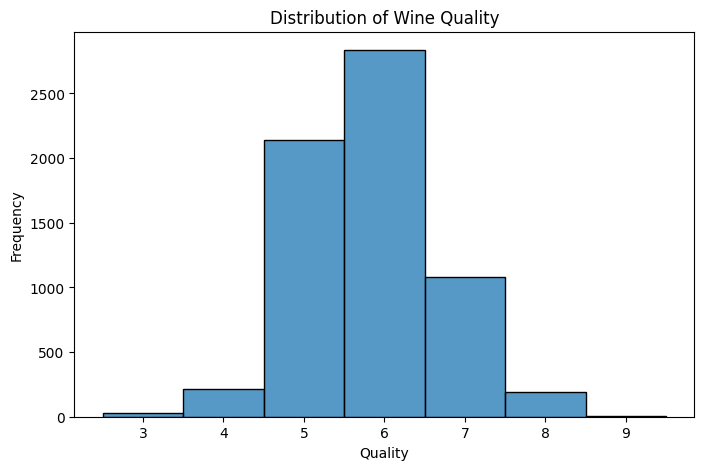

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(data=dt, x='quality', 
             bins=range(dt['quality'].min(), dt['quality'].max() + 2), 
             edgecolor='black', kde=False, discrete=True, multiple='stack')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Quality')
plt.show()

## Preprocessing

+ While building machine learning models, we will apply one or more [preprocessing or feature engineering steps](https://scikit-learn.org/stable/modules/preprocessing.html#) to the data.
+ The most practical way to do this is by arranging the preprocessing steps in `Pipeline` objects, which are sequential transformations applied to data. After preprocessing, we pass the data to our model. 
+ It is convenient for us to label these transformations, and there is a standard way of doing so.

## Transformations

Transformations are classes that implement `fit` and `transform` methods.

### StandardScaler

For example, transform a numerical variable by standardizing it. Standardization removes the mean of each feature and scales it by dividing each non-constant feature by its standard deviation.

$$
z = \frac{x-\mu}{\sigma}
$$


Using [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), one can do the following:

In [18]:
X.select_dtypes(include=['int64', 'float64']).columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [19]:
# Create a StandardScaler object
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

# Select only numeric features for scaling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
X_num = X[numeric_features]

# Fit the StandardScaler object with the returns data
std_scaler.fit(X_num)

,copy,True
,with_mean,True
,with_std,True


In [20]:
X_num.mean()

fixed_acidity             7.215307
volatile_acidity          0.339666
citric_acid               0.318633
residual_sugar            5.443235
chlorides                 0.056034
free_sulfur_dioxide      30.525319
total_sulfur_dioxide    115.744574
density                   0.994697
pH                        3.218501
sulphates                 0.531268
alcohol                  10.491801
dtype: float64

In [21]:
# Transform the returns data using the fitted scaler

scaled_X = std_scaler.transform(X_num)
scaled_X_df = pd.DataFrame(scaled_X, columns=X_num.columns)

In [22]:
scaled_X

array([[ 0.14247327,  2.18883292, -2.19283252, ...,  1.81308951,
         0.19309677, -0.91546416],
       [ 0.45103572,  3.28223494, -2.19283252, ..., -0.11507303,
         0.99957862, -0.58006813],
       [ 0.45103572,  2.55330026, -1.91755268, ...,  0.25811972,
         0.79795816, -0.58006813],
       ...,
       [-0.55179227, -0.6054167 , -0.88525328, ..., -1.42124765,
        -0.47897144, -0.91546416],
       [-1.32319841, -0.30169391, -0.12823371, ...,  0.75571005,
        -1.016626  ,  1.9354021 ],
       [-0.93749534, -0.78765037,  0.42232597, ...,  0.25811972,
        -1.41986693,  1.09691202]], shape=(6497, 11))

In [23]:
scaled_X_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464
1,0.451036,3.282235,-2.192833,-0.597640,1.197975,-0.311320,-0.862469,0.701486,-0.115073,0.999579,-0.580068
2,0.451036,2.553300,-1.917553,-0.660699,1.026697,-0.874763,-1.092486,0.768188,0.258120,0.797958,-0.580068
3,3.073817,-0.362438,1.661085,-0.744778,0.541412,-0.762074,-0.986324,1.101694,-0.363868,0.327510,-0.580068
4,0.142473,2.188833,-2.192833,-0.744778,0.569958,-1.100140,-1.446359,1.034993,1.813090,0.193097,-0.915464
...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783214,-0.787650,-0.197054,-0.807837,-0.486252,-0.367664,-0.420128,-1.186161,0.320319,-0.210144,0.593818
6493,-0.474652,-0.119460,0.284686,0.537425,-0.257883,1.491697,0.924588,0.067824,-0.426067,-0.478971,-0.747766
6494,-0.551792,-0.605417,-0.885253,-0.891916,-0.429160,-0.029599,-0.083949,-0.719251,-1.421248,-0.478971,-0.915464
6495,-1.323198,-0.301694,-0.128234,-0.912936,-0.971538,-0.593041,-0.101642,-2.003251,0.755710,-1.016626,1.935402


In [24]:
scaled_X_df.mean()

fixed_acidity          -3.849639e-16
volatile_acidity        1.049902e-16
citric_acid             2.187295e-17
residual_sugar          3.499672e-17
chlorides               1.749836e-17
free_sulfur_dioxide    -8.749179e-17
total_sulfur_dioxide   -6.999344e-17
density                -3.552167e-15
pH                      2.729744e-15
sulphates              -5.424491e-16
alcohol                 6.561885e-16
dtype: float64

In [25]:
X_num.std()

fixed_acidity            1.296434
volatile_acidity         0.164636
citric_acid              0.145318
residual_sugar           4.757804
chlorides                0.035034
free_sulfur_dioxide     17.749400
total_sulfur_dioxide    56.521855
density                  0.002999
pH                       0.160787
sulphates                0.148806
alcohol                  1.192712
dtype: float64

In [26]:
scaled_X_df.std()

fixed_acidity           1.000077
volatile_acidity        1.000077
citric_acid             1.000077
residual_sugar          1.000077
chlorides               1.000077
free_sulfur_dioxide     1.000077
total_sulfur_dioxide    1.000077
density                 1.000077
pH                      1.000077
sulphates               1.000077
alcohol                 1.000077
dtype: float64

###  OneHotEncoder

Categorical features can be encoded as numerical values using `OneHotEncoder`.

<Axes: xlabel='color'>

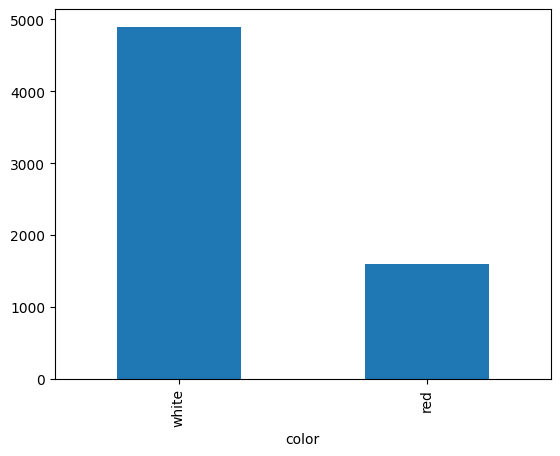

In [27]:
X['color'].value_counts().plot(kind = 'bar')

In [29]:
X['color']

0         red
1         red
2         red
3         red
4         red
        ...  
6492    white
6493    white
6494    white
6495    white
6496    white
Name: color, Length: 6497, dtype: object

Use [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode a categorical variable as numerical.

Some key parameters are:

- `categories` allows you to specify the categories to work with.
- `drop`: we can drop the `'first'` value (dummy encoding) or `'if_binary'`, a convenience setting for binary values.
- `handle_unknown` allows three options, `'error'`, `'ignore'`, and `'infrequent_if_exist'`, depending on what we want to do with new values.

In [32]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(drop='if_binary')
# onehot = OneHotEncoder()
onehot.fit(X[['color']])

,categories,'auto'
,drop,'if_binary'
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [33]:
listing_enc = onehot.transform(X[['color']])
listing_enc.toarray()

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], shape=(6497, 1))

# Pipelines

+ It is impractical and costly to manipulate data "by hand". 
+ To manage data preprocessing steps within the cross-validation process, use `Pipeline` objects.
+ A [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object allows us to sequentially apply transformation steps and, if required, a predictor.
+ `Pipeline` objects compose transforms, i.e., classes that implement `transform` and `fit` methods.
+ The purpose of `Pipeline` objects is to ensemble transforms and predictors to be used in cross-validation.
+ A `Pipeline` is defined by a list of tuples.
+ Each tuple is composed of `("name", <ColumnTransformer>)`, the name of the step, and the `<ColumnTransformer>` function of our choosing.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score


In [37]:
pipe1 = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression())

    ]
)
pipe1

,steps,"[('scaler', ...), ('logistic', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [38]:

X0_train, X0_test, Y0_train, Y0_test = train_test_split(X_num, Y, test_size=0.2, random_state=42)

pipe1.fit(X0_train, Y0_train)

,steps,"[('scaler', ...), ('logistic', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [39]:
Y_pred_train = pipe1.predict(X0_train)
Y_pred_test = pipe1.predict(X0_test)

In [40]:
Y_poba_train = pipe1.predict_proba(X0_train)
Y_proba_test = pipe1.predict_proba(X0_test)

In [42]:
Y_pred_test, Y_proba_test

(array([1, 0, 0, ..., 1, 0, 0], shape=(1300,)),
 array([[0.37689078, 0.62310922],
        [0.98447773, 0.01552227],
        [0.5968582 , 0.4031418 ],
        ...,
        [0.2699949 , 0.7300051 ],
        [0.96580257, 0.03419743],
        [0.94135441, 0.05864559]], shape=(1300, 2)))

In [43]:
res = {
    'accuracy_score_train': accuracy_score(Y0_train, Y_pred_train),
    'accuracy_score_test': accuracy_score(Y0_test, Y_pred_test),
    'cohen_kappa_train': cohen_kappa_score(Y0_train, Y_pred_train),
    'cohen_kappa_test': cohen_kappa_score(Y0_test, Y_pred_test),
    'log_loss_train': log_loss(Y0_train, Y_poba_train),
    'log_loss_test': log_loss(Y0_test, Y_proba_test),
    'f1_score_train': f1_score(Y0_train, Y_pred_train),
    'f1_score_test': f1_score(Y0_test, Y_pred_test)
}
res

{'accuracy_score_train': 0.8158553011352704,
 'accuracy_score_test': 0.8246153846153846,
 'cohen_kappa_train': 0.2699202282221784,
 'cohen_kappa_test': 0.28878565669750833,
 'log_loss_train': 0.3923764270420573,
 'log_loss_test': 0.389396105952525,
 'f1_score_train': 0.36072144288577157,
 'f1_score_test': 0.37362637362637363}

Below, we expand the pipeline to include more variables, and further, we will work with more robust model selection pipelines.

## ColumnTransformer

+ Use [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply transformers to specific columns of a DataFrame.
+ In this case, we will scale numeric variables and apply one-hot encoding to categorical columns.

In [44]:
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(
    transformers=[
        ('num_transform', StandardScaler(), X_num.columns.values ),
        ('cat_transform', OneHotEncoder(handle_unknown='infrequent_if_exist', drop='if_binary'), ['color']), 
    ], remainder='drop'
)

pipe = Pipeline(
    [
        ('preproc', transformer), 
        ('logistic', LogisticRegression(l1_ratio=1.0))
    ]
)
pipe

,steps,"[('preproc', ...), ('logistic', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_transform', ...), ('cat_transform', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Model Selection

The model selection process is an iterative process in which :

+ Select schema and load data.
+ Define the pipeline and its (hyper)parameters.

    - Use ColumnTransformers to transform numeric and categorical variables.
    - Hyperparameters can be defined independently of code. 

+ Implement a splitting strategy. 

    - Use [cross_validate]() to select several metrics and operational details.

+ Measure performance.

    - [Select metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

+ Repeat

## Training, Validation, Testing Split

+ The first splitting strategy is to use a training, validation, and test set.
+ The training set will be used to fit the model.
+ The validation set is used to evaluate hyperparameter choices.
+ Testing set is used to evaluate performance on data the model has not yet seen.
+ In this case, we want to compare two models: 

    - Decision Tree with 3 minimum samples per leaf.
    - Decision Tree with 10 minimum samples per leaf.

![](./images/03b_train_validate_test.png)

## Setting parameters in pipeline steps

+ One can obtain the parameters of a pipeline with `pipe.get_params()`.
+ We can set any parameter of a pipeline with `pipe.set_parames(**kwargs)`. 
+ The input `**kwargs` is a dictionary of the params to be modified. Params of the steps are labeled with the name of the step followed by `__` and the name of the parameter.
+ There are a few steps that we will repeat: 

    - Fit the candidate model on training data.
    - Predict on training and test data.
    - Compute training and test performance metrics.
    - Return.

+ We encapsulate this procedure in a function. 


In [45]:
def evaluate_model(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train)
    Y_pred_train = clf.predict(X_train)
    Y_pred_test = clf.predict(X_test)
    Y_proba_train = clf.predict_proba(X_train)
    Y_proba_test = clf.predict_proba(X_test)
    performance_metrics = {
        'log_loss_train': log_loss(Y_train, Y_proba_train),
        'log_loss_test': log_loss(Y_test, Y_proba_test),
        'cohen_kappa_train': cohen_kappa_score(Y_train, Y_pred_train),
        'cohen_kappa_test': cohen_kappa_score(Y_test, Y_pred_test),
        'f1_score_train': f1_score(Y_train, Y_pred_train),
        'f1_score_test': f1_score(Y_test, Y_pred_test),
        'accuracy_score_train': accuracy_score(Y_train, Y_pred_train),
        'accuracy_score_test': accuracy_score(Y_test, Y_pred_test),
    }
    return performance_metrics

In [46]:
# Split the data
X_rest, X_test, Y_rest, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_validate, Y_train,  Y_validate = train_test_split(X_rest, Y_rest, test_size=0.2, random_state=42)


In [47]:

# Evaluate hyperparameter configuration 2
pipe_1 = pipe.set_params(**{'logistic__C': 0.0001})
res_1 = evaluate_model(pipe_1, X_train, Y_train, X_validate, Y_validate)
res_1

c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


{'log_loss_train': 0.4779626346548836,
 'log_loss_test': 0.4907357986185722,
 'cohen_kappa_train': 0.0,
 'cohen_kappa_test': 0.0,
 'f1_score_train': 0.0,
 'f1_score_test': 0.0,
 'accuracy_score_train': 0.80442626894395,
 'accuracy_score_test': 0.7961538461538461}

In [48]:
# Evaluate hyperparameter configuration 2
pipe_2 = pipe.set_params(**{'logistic__C': 1.0})
res_2 = evaluate_model(pipe_2, X_train, Y_train, X_validate, Y_validate)
res_2

c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


{'log_loss_train': 0.38762707605806057,
 'log_loss_test': 0.4093147504926842,
 'cohen_kappa_train': 0.27982670126628817,
 'cohen_kappa_test': 0.22375979851147532,
 'f1_score_train': 0.3698744769874477,
 'f1_score_test': 0.3258785942492013,
 'accuracy_score_train': 0.8188597546307433,
 'accuracy_score_test': 0.7971153846153847}

## Cross-Validation

+ Cross-validation is a resampling method.
+ It is an iterative method applied to training data.
+ Training data is divided into folds.
+ Each fold is used once as a validation set and the rest of the folds are used for training.
+ Test data is used for final evaluation.

From [Scikit's Documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance), the diagram below shows the data divisions and folds used during cross-validation.

![](./images/03b_grid_search_cross_validation.png)

There are two functions that can be used for [calculating cross-validation performance scores](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance): `cross_val_score()` and `cross_validate()`. The first function, [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score), is a convenience function to get quick performance calculations. We will discuss `cross_validate()`, which offers advantages over `cross_val_score()`.

## Obtaining metrics

+ Use [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) to measure one or more performance metrics and operational details.
+ There are two advantages of using this function. From [Scikit's documentation](https://scikit-learn.org/stable/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation):

>- It allows specifying multiple metrics for evaluation.
>- It returns a dict containing fit-times, score-times (and optionally training scores, fitted estimators, train-test split indices) in addition to the test score.

In [49]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'neg_log_loss']

dict_1 = cross_validate(pipe_1, X, Y, cv=5, scoring = scoring, return_train_score = True)

c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_lo

In DataFrame form:

In [50]:
pd.DataFrame(dict_1)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss
0,0.027247,0.015049,0.807692,0.819126,0.045802,0.364865,1.000000,0.588235,0.023438,0.264447,0.870615,0.809813,-0.828783,-0.390220
1,0.015033,0.013049,0.810000,0.823167,0.210863,0.390179,0.578947,0.604938,0.128906,0.287953,0.770467,0.819708,-0.434341,-0.385785
2,0.015072,0.014028,0.815242,0.817237,0.298246,0.363271,0.586207,0.576596,0.200000,0.265166,0.790425,0.815058,-0.404547,-0.389101
3,0.019030,0.022033,0.816782,0.816083,0.478070,0.341598,0.542289,0.576744,0.427451,0.242661,0.849684,0.808025,-0.386331,-0.394482
4,0.018406,0.020050,0.775982,0.827241,0.419162,0.429479,0.426829,0.612319,0.411765,0.330724,0.735257,0.832491,-0.467729,-0.374899


In [ ]:
dict_2 = cross_validate(pipe_2, X, Y, cv=5, scoring = scoring, return_train_score = True, random_state=42)
pd.DataFrame(dict_2)

c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\JesusCalderon\work\dsi_production\production-env\Lib\site-packages\sklearn\linear_model\_lo

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_precision,train_precision,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss
0,0.022984,0.020527,0.807692,0.819126,0.045802,0.364865,1.000000,0.588235,0.023438,0.264447,0.870615,0.809813,-0.828783,-0.390220
1,0.015230,0.015601,0.810000,0.823167,0.210863,0.390179,0.578947,0.604938,0.128906,0.287953,0.770467,0.819708,-0.434341,-0.385785
2,0.011041,0.012208,0.815242,0.817237,0.298246,0.363271,0.586207,0.576596,0.200000,0.265166,0.790425,0.815058,-0.404547,-0.389101
3,0.016221,0.019623,0.816782,0.816083,0.478070,0.341598,0.542289,0.576744,0.427451,0.242661,0.849684,0.808025,-0.386331,-0.394482
4,0.018594,0.019599,0.775982,0.827241,0.419162,0.429479,0.426829,0.612319,0.411765,0.330724,0.735257,0.832491,-0.467729,-0.374899


# About Performance

+ Notice that in order to acquire information about our model and continue development, we are spending resources: time, electricity, equipment use, etc. We are also generating data and binary objects that implement our models (e.g., fitted `Pipeline` objects).
+ For certain applications, operating performance (latency or `'score_time'`) may be as important or more important than predictive performance metrics. 
+ Every experiment throws important information, and we can log them, as well as run them systematically.

In [52]:
pd.DataFrame(dict_1).mean()

fit_time              0.018958
score_time            0.016842
test_accuracy         0.805140
train_accuracy        0.820571
test_f1               0.290428
train_f1              0.377878
test_precision        0.626854
train_precision       0.591766
test_recall           0.238312
train_recall          0.278190
test_roc_auc          0.803290
train_roc_auc         0.817019
test_neg_log_loss    -0.504346
train_neg_log_loss   -0.386897
dtype: float64

In [54]:
Y

array([0, 0, 0, ..., 0, 1, 0], shape=(6497,))

In [53]:
pd.DataFrame(dict_2).mean()

fit_time              0.016814
score_time            0.017511
test_accuracy         0.805140
train_accuracy        0.820571
test_f1               0.290428
train_f1              0.377878
test_precision        0.626854
train_precision       0.591766
test_recall           0.238312
train_recall          0.278190
test_roc_auc          0.803290
train_roc_auc         0.817019
test_neg_log_loss    -0.504346
train_neg_log_loss   -0.386897
dtype: float64